# Feature engineering


Add more features:

1. Holidays
2. Weather

In [64]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = 0 # Enter your code here 

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

In [65]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#!wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv to ../project/data/daily-summaries.csv


Import the weather data that was prepared for the airport codes in the dataset. Use the following stations and airports  for the analysis. Create a new column called *airport* that maps the weather station to the airport name.

In [66]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')
station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

From the DATE column, create another column called MONTH.

In [67]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


In [68]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

In [70]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather.TAVG.isna()] 
TMAX_idx = idx[weather.TMAX.isna()]
TMIN_idx = idx[weather.TMIN.isna()]
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

In [71]:
weather_impute = weather.groupby(['MONTH', 'STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


Merge the mean data with the weather data.

In [72]:

weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [73]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

In [74]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [75]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

check for nulls or NA

In [76]:
sum(data.isna().any())

0

In [77]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data by using one-hot encoding.

In [78]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [79]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

In [80]:
data.shape

(1635590, 85)

In [81]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

In [82]:
data.rename(columns = {'is_delay':'target'}, inplace=True ) #rename

In [84]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2 , random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test 
train, validate , test = split_data(data)
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

0.0    1033806
1.0     274666
Name: target, dtype: int64
0.0    129226
1.0     34333
Name: target, dtype: int64
0.0    129226
1.0     34333
Name: target, dtype: int64


### New baseline classifier

check if the new features added any predictive power 

In [85]:
# Instantiate the LinearLearner estimator object
classifier_estimator2 =sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')

In [86]:
train_records = classifier_estimator2.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator2.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator2.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Train your model by using the three datasets that you just created.

In [87]:
classifier_estimator2.fit([train_records, val_records , test_records])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-06-14-07-53-25-190


2023-06-14 07:53:25 Starting - Starting the training job...
2023-06-14 07:53:51 Starting - Preparing the instances for training.........
2023-06-14 07:54:58 Downloading - Downloading input data...
2023-06-14 07:55:43 Training - Downloading the training image......
2023-06-14 07:56:43 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/14/2023 07:57:02 INFO 140444477814592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

Perform a batch prediction by using the newly trained model.

In [88]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator2)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-06-14-08-04-58-257
INFO:sagemaker:Creating transform job with name: linear-learner-2023-06-14-08-04-59-077


.......................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/14/2023 08:11:33 INFO 140622492612416] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[06/14/2023 08:11:38 WARNING 140622492612416] Loggers have already been setup.
[06/14/2023 08:11:38 INFO 140622492612416] loaded entry point class algorithm.serve.server_config:config_api
[06/14/2023 08:11:38 INFO 140622492612416] loading entry points
[06/14/2023 08:11:38 INFO 140622492612416] loaded request iterator application/json
[06/14/2023 08:11:38 INFO 140622492612416] loaded request iterator application/jsonlines
[06/14/2023 08:11:38 INFO 140622492612416] loaded request iterator application/x-recordio-protobuf
[06/14/2023 08:11:38 INFO 140622492612416] loaded request iterator text/csv
[06/14/2023 08:11:38 INFO 140622492612416] loaded response encoder application/json
[06/14/2023 08:11:38 INFO 140622492612416] loaded response e

Plot a confusion matrix.

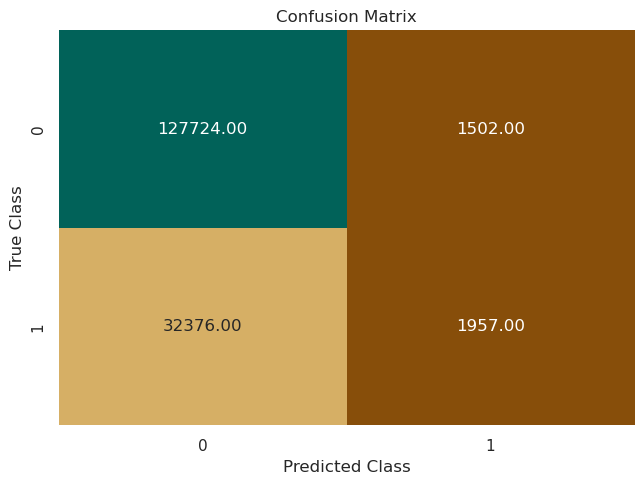

In [89]:
plot_confusion_matrix(test_labels , target_predicted)

Plot the ROC curve.

Sensitivity or TPR:  5.70005534034311 %
Specificity or TNR:  98.83769520065621 %
Precision:  56.57704538884071 %
Negative Predictive Value:  79.77763897564022 %
False Positive Rate:  1.1623047993437854 %
False Negative Rate:  94.29994465965689 %
False Discovery Rate:  43.42295461115929 %
Accuracy:  79.28698512463393 %
Validation AUC 0.5226887527049966
Figure(640x480)


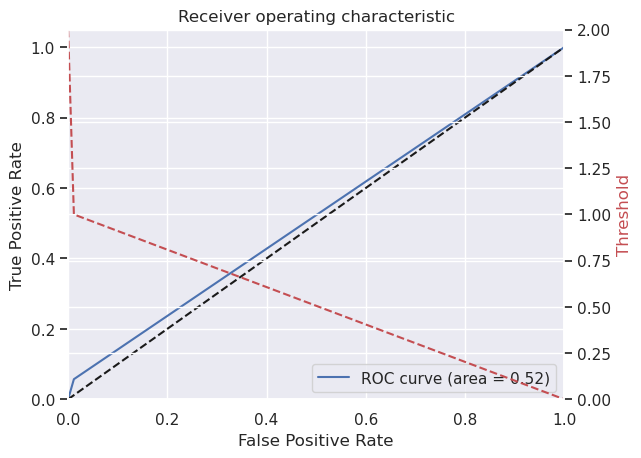

<Figure size 640x480 with 0 Axes>

In [90]:
plot_roc(test_labels, target_predicted)

The linear model shows only a little improvement in performance. Try a tree-based ensemble model, which is called *XGBoost*, with Amazon SageMaker.